In [61]:
from bitarray import bitarray
from hashlib import sha256, blake2b, sha3_256

# Define Bloom filter size
size = 1000000  # You can adjust this size for different trade-offs in accuracy and memory

# Create bitarray for the Bloom Filter and initialize all bits to 0
bloom_filter = bitarray(size)
bloom_filter.setall(0)

# Define hash functions
def my_hash(s):
    return int(sha256(s.lower().encode()).hexdigest(), 16) % size

def my_hash2(s):
    return int(blake2b(s.lower().encode()).hexdigest(), 16) % size

def my_hash3(s):
    return int(sha3_256(s.lower().encode()).hexdigest(), 16) % size

# Populate Bloom Filter with words from the words.txt file
with open('words.txt') as f:
    for line in f:
        word = line.strip()
        
        # Apply hash functions and set corresponding bits in the Bloom filter
        bloom_filter[my_hash(word)] = 1
        bloom_filter[my_hash2(word)] = 1
        bloom_filter[my_hash3(word)] = 1

print("Bloom filter populated with words from words.txt")


Bloom filter populated with words from words.txt


In [68]:
from bitarray import bitarray
from hashlib import sha3_256, sha256, blake2b
import json
import string

# Bloom Filter 
class BloomFilter:
    def __init__(self, size, num_hashes):
        self.size = size
        self.num_hashes = num_hashes
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.hash_functions = [self.my_hash, self.my_hash2, self.my_hash3] #three hashes

    def my_hash(self, s):
        return int(sha256(s.lower().encode()).hexdigest(), 16) % self.size

    def my_hash2(self, s):
        return int(blake2b(s.lower().encode()).hexdigest(), 16) % self.size

    def my_hash3(self, s):
        return int(sha3_256(s.lower().encode()).hexdigest(), 16) % self.size

    def add(self, word):
        for i in range(self.num_hashes): 
            index = self.hash_functions[i](word)
            self.bit_array[index] = True

    def might_contain(self, word):
        for i in range(self.num_hashes): 
            index = self.hash_functions[i](word)
            if not self.bit_array[index]:
                return False
        return True

# spell check using single-character substitutions
def spell_check(word, bloom_filter):
    alphabet = string.ascii_lowercase
    suggestions = set()

    # Single character substitutions, we regard these substitutions as potential suggestions, we will check if they are real suggestions
    for i in range(len(word)):
        for char in alphabet:
            new_word = word[:i] + char + word[i+1:]
            if bloom_filter.might_contain(new_word):
                suggestions.add(new_word)
    
    return list(suggestions)

# Evaluate results
def evaluate_performance(bloom_filter, dataset):
    typo_total = 0
    good_suggestions = 0
    misidentified_count = 0

    for typed_word, correct_word in dataset:
        if typed_word != correct_word:  # the typed word is a misspelled one if they are not identical.
            typo_total += 1
            suggestions = spell_check(typed_word, bloom_filter)

            # Good suggestion
            if len(suggestions) <= 3 and correct_word in suggestions:
                good_suggestions += 1

            # Misidentified
            if bloom_filter.might_contain(typed_word):
                misidentified_count += 1


    # Good suggestion
    good_suggestion_percentage = (good_suggestions / typo_total) * 100

    # Misidentified percentage: cases where typed_word is in the Bloom filter but is not correct_word
    misidentified_rate = (misidentified_count / typo_total) * 100

    return good_suggestion_percentage, misidentified_rate

size = int(1e7) 
num_hashes = 3 
bloom_filter = BloomFilter(size, num_hashes)

with open('words.txt') as f:
    for line in f:
        word = line.strip()
        bloom_filter.add(word)
#Use the given example for experiment
typo = "floeer"
suggestions = spell_check(typo, bloom_filter)
print(f"Suggestions for '{typo}': {suggestions}")

with open('typos.json') as f:
    dataset = json.load(f)

performance = evaluate_performance(bloom_filter, dataset)
print(f"Performance: {performance}%")


Suggestions for 'floeer': ['flower', 'floter']
Performance: (91.74799999999999, 0.20400000000000001)%


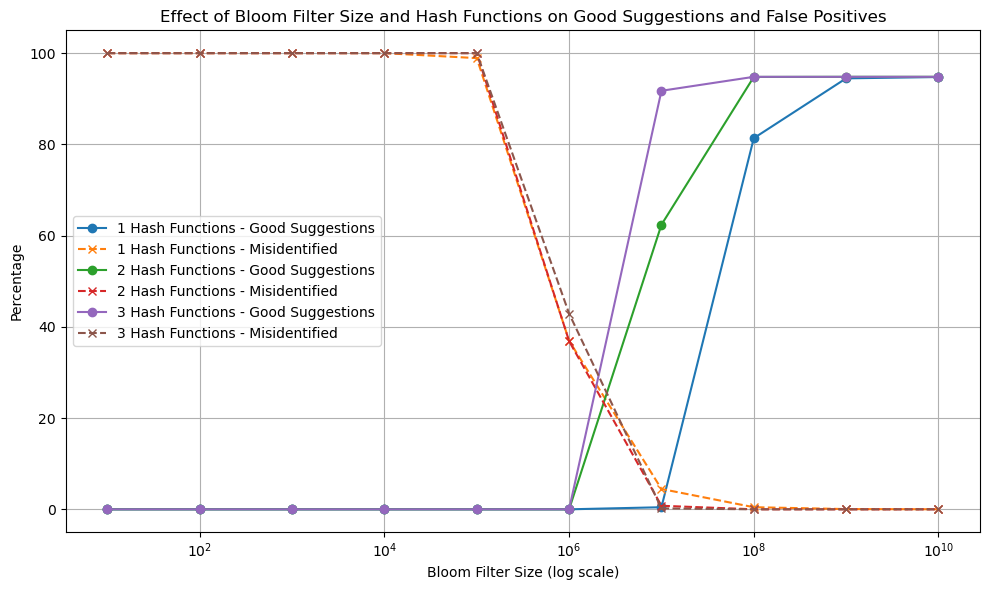

In [78]:
import matplotlib.pyplot as plt

def experiment_and_plot(bloom_filter_sizes, num_hash_functions_list, dataset):
    results = []

    # Experiment with varying filter sizes and number of hash functions
    for size in bloom_filter_sizes:
        for num_hashes in num_hash_functions_list:
            # Initialize a new Bloom filter with the specified size and number of hash functions
            bloom_filter = BloomFilter(size, num_hashes)
            
            with open('words.txt') as f:
                for line in f:
                    word = line.strip()
                    bloom_filter.add(word)

            # Evaluate the performance
            good_suggestion_percentage, misidentified_rate = evaluate_performance(bloom_filter, dataset)
            
            # Store results
            results.append({
                'size': size,
                'hashes': num_hashes,
                'good_suggestions': good_suggestion_percentage,
                'misidentified': misidentified_rate
            })
    plot_combined_results(results)

## Single y-axis for both metrics
def plot_combined_results(results):
    sizes = sorted(list(set([result['size'] for result in results])))
    num_hashes_list = sorted(list(set([result['hashes'] for result in results])))

    plt.figure()

    # Plot both Good Suggestions and Misidentified on the same axis 
    #I ask ChatGPT for help and it separates the good_suggestion and misidentified from the results list.
    for num_hashes in num_hashes_list:
        x = [result['size'] for result in results if result['hashes'] == num_hashes]
        y_good = [result['good_suggestions'] for result in results if result['hashes'] == num_hashes]
        y_misidentified = [result['misidentified'] for result in results if result['hashes'] == num_hashes]

        plt.plot(x, y_good, marker='o', linestyle='-', label=f'{num_hashes} Hash Functions - Good Suggestions')
        plt.plot(x, y_misidentified, marker='x', linestyle='--', label=f'{num_hashes} Hash Functions - Misidentified')

    plt.xscale('log')
    plt.xlabel('Bloom Filter Size (log scale)')
    plt.ylabel('Percentage')
    plt.title('Effect of Bloom Filter Size and Hash Functions on Good Suggestions and False Positives')
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(0, 0.5))# arrage the position of the legend

    plt.tight_layout()
    plt.show()

# Experiment parameters
bloom_filter_sizes = [int(1e1),int(1e2),int(1e3),int(1e4),int(1e5), int(1e6), int(1e7), int(1e8), int(1e9), int(1e10)]  # Filter sizes
num_hash_functions_list = [1, 2, 3]  # Number of hash functions

# Load the dataset (typos.json)
with open('typos.json') as f:
    dataset = json.load(f)

# Run the experiment and plot results
experiment_and_plot(bloom_filter_sizes, num_hash_functions_list, dataset)


### Exercise 2

In [1]:
def alg2_key(data, key):
    if len(data) <= 1:
        return data
    else:
        split = len(data) // 2
        left = iter(alg2_key(data[:split], key))
        right = iter(alg2_key(data[split:], key))
        result = []
        
        left_top = next(left)
        right_top = next(right)
        
        while True:
            if left_top[key] < right_top[key]:
                result.append(left_top)
                try:
                    left_top = next(left)
                except StopIteration:
                    # nothing remains on the left; add the right + return
                    return result + [right_top] + list(right)
            else:
                result.append(right_top)
                try:
                    right_top = next(right)
                except StopIteration:
                    # nothing remains on the right; add the left + return
                    return result + [left_top] + list(left)


In [2]:
data = [
    {'patient_id': 3, 'patient_data': 'A'},
    {'patient_id': 1, 'patient_data': 'B'},
    {'patient_id': 4, 'patient_data': 'C'},
    {'patient_id': 2, 'patient_data': 'D'}
]

sorted_data = alg2_key(data, 'patient_id')
print(sorted_data)


[{'patient_id': 1, 'patient_data': 'B'}, {'patient_id': 2, 'patient_data': 'D'}, {'patient_id': 3, 'patient_data': 'A'}, {'patient_id': 4, 'patient_data': 'C'}]


### Exercise 3

In [24]:
import requests
import xml.etree.ElementTree as ET
import time

def get_id(disease):
    # Make the request to PubMed API
    r = requests.get(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?"
        f"db=pubmed&term={disease}+AND+2023[pdat]&retmode=xml&retmax=1000"
    )
    # Respect rate limit
    time.sleep(1)

    # Check for successful response
    if r.status_code == 200:
        # Parse the XML response
        root = ET.fromstring(r.content)
        
        # Extract all PubMed IDs
        pubmed_ids = [id_elem.text for id_elem in root.findall(".//Id")]
        return pubmed_ids
    else:
        # Error handling
        print("Failed to fetch IDs:", r.status_code)
        return []



In [25]:
def get_text(element):
    """Helper function to retrieve text content from an ElementTree node and its children."""
    return ''.join(element.itertext())

def get_metadata(id_list, query_term):
    metadata_dict = {}
    
    if id_list:
        # Make the POST request to fetch metadata
        r = requests.post(
            "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi",
            data={
                "db": "pubmed",
                "retmode": "xml",
                "id": ",".join(id_list)
            }
        )
        
        # Respect API rate limiting
        time.sleep(1)
        
        if r.status_code == 200:
            # Parse the XML response using ElementTree and iterate through PubmedArticle nodes
            root = ET.fromstring(r.content)
            articles = root.findall(".//PubmedArticle")
            
            for article, pubmed_id in zip(articles, id_list):
                # Extract title using ElementTree
                title_elem = article.find(".//ArticleTitle")
                title = get_text(title_elem) if title_elem is not None else "" #Some abstract context is missing
                
                # Extract abstract using ElementTree, and handle multiple parts of structured abstracts
                abstract_elems = article.findall(".//AbstractText")
                abstract = " ".join(get_text(abstract_elem) for abstract_elem in abstract_elems) if abstract_elems else ""
                
                # Store the metadata in the dictionary
                metadata_dict[pubmed_id] = {
                    "ArticleTitle": title,
                    "AbstractText": abstract,
                    "query": query_term
                }

    
    return metadata_dict


In [26]:
if __name__ == "__main__":
    Alzheimers_id = get_id("Alzheimers")
    Cancer_id = get_id("cancer")

    common_ids = list(set(Alzheimers_id) & set(Cancer_id))
    print("Common IDs:", common_ids)

    Alzheimers_metadata = get_metadata(Alzheimers_id, "Alzheimers")
    Cancer_metadata = get_metadata(Cancer_id, "cancer")

    all_metadata = {**Alzheimers_metadata, **Cancer_metadata}
    with open('metadata.json', 'w') as f:
        json.dump(all_metadata, f, indent=4)

Common IDs: ['38694619', '38948505', '39280063']


### Exercise 4

In [79]:
from transformers import AutoTokenizer, AutoModel

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [80]:
import json
with open('metadata.json') as f:
    papers = json.load(f)
import tqdm

# we can use a persistent dictionary (via shelve) so we can stop and restart if needed
# alternatively, do the same but with embeddings starting as an empty dictionary
embeddings = {}
for pmid, paper in tqdm.tqdm(papers.items()):
    data = [paper["ArticleTitle"] + tokenizer.sep_token + "".join(paper["AbstractText"])]
    inputs = tokenizer(
        data, padding=True, truncation=True, return_tensors="pt", max_length=512
    )
    result = model(**inputs)
    # take the first token in the batch as the embedding
    embeddings[pmid] = result.last_hidden_state[:, 0, :].detach().numpy()[0]

# turn our dictionary into a list
embeddings = [embeddings[pmid] for pmid in papers.keys()]

100%|██████████| 1997/1997 [02:36<00:00, 12.78it/s]


In [82]:
embeddings[0].size

768

In [83]:
from sklearn import decomposition
import pandas as pd

pca = decomposition.PCA(n_components=3)
embeddings_pca = pd.DataFrame(
    pca.fit_transform(embeddings),
    columns=['PC0', 'PC1', 'PC2']
)
embeddings_pca["query"] = [paper["query"] for paper in papers.values()]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [84]:
embeddings_pca

,PC0,PC1,PC2,query
0,-4.603137,-2.170447,-1.526437,Alzheimers
1,-7.595276,0.435876,-1.645755,Alzheimers
2,-6.625034,-2.008937,-1.253660,Alzheimers
3,-5.550500,2.311249,-4.340761,Alzheimers
4,-5.913295,3.007254,-0.234550,Alzheimers
...,...,...,...,...
1992,0.697405,-3.691629,5.893336,cancer
1993,3.340729,-1.148313,6.953101,cancer
1994,9.356931,-1.196874,-3.162101,cancer
1995,3.036748,-4.447534,6.247646,cancer


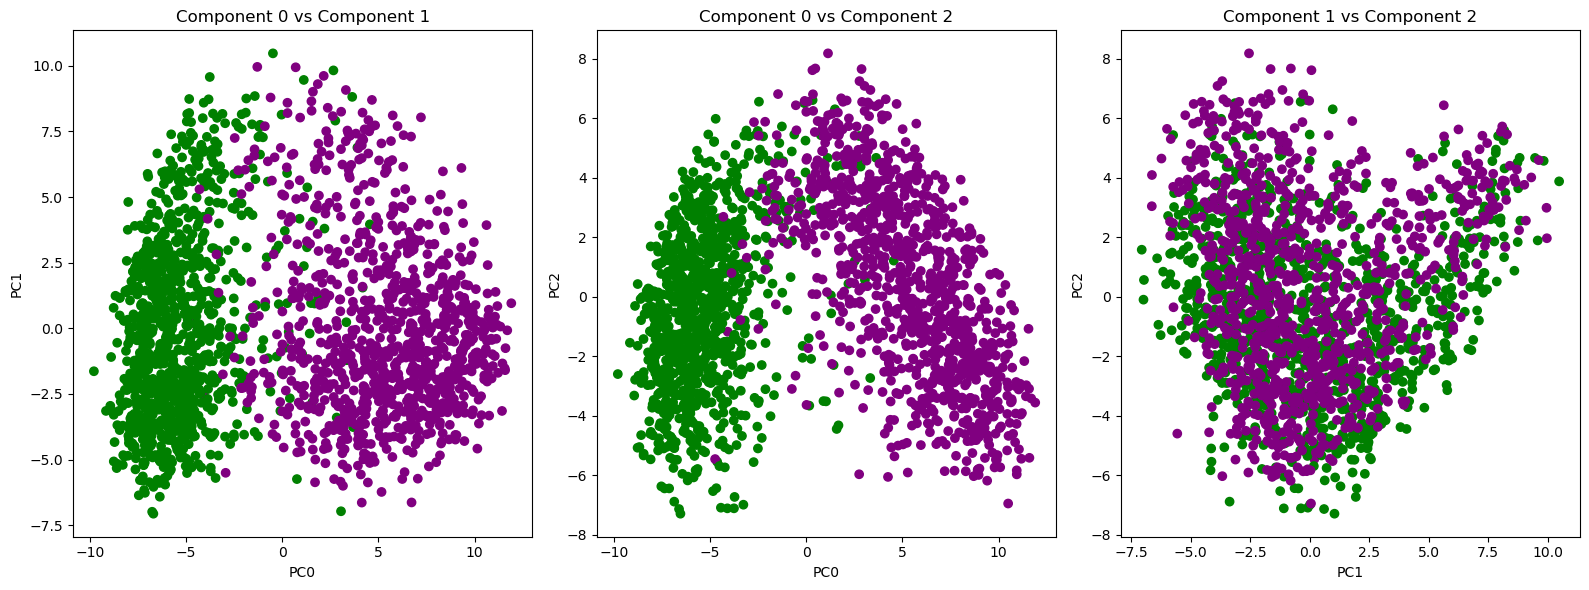

In [90]:
# Plot 2D scatter plots
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# PC0 vs PC1
axes[0].scatter(embeddings_pca["PC0"], embeddings_pca["PC1"], c=embeddings_pca["query"].map({"Alzheimers": "green", "cancer": "purple"}))
axes[0].set_title('Component 0 vs Component 1')
axes[0].set_xlabel('PC0')
axes[0].set_ylabel('PC1')

# PC0 vs PC2
axes[1].scatter(embeddings_pca["PC0"], embeddings_pca["PC2"], c=embeddings_pca["query"].map({"Alzheimers": "green", "cancer": "purple"}))
axes[1].set_title('Component 0 vs Component 2')
axes[1].set_xlabel('PC0')
axes[1].set_ylabel('PC2')

# PC1 vs PC2
axes[2].scatter(embeddings_pca["PC1"], embeddings_pca["PC2"], c=embeddings_pca["query"].map({"Alzheimers": "green", "cancer": "purple"}))
axes[2].set_title('Component 1 vs Component 2')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')

plt.tight_layout()
plt.show()
